<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

!apt autoremove

dolfin version: 2019.1.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libnvidia-common-410
0 upgraded, 0 newly installed, 1 to remove and 30 not upgraded.
After this operation, 33.8 kB disk space will be freed.
(Reading database ... 144035 files and directories currently installed.)
Removing libnvidia-common-410 (410.104-0ubuntu1) ...


In [71]:
!apt install octave
# from oct2py import octave
!python3 -m pip install oct2py
from oct2py import Oct2Py
oc = Oct2Py()

function r = robertson_dae (t, y)
  r = [ -0.04*y(1) + 1e4*y(2)*y(3)
         0.04*y(1) - 1e4*y(2)*y(3) - 3e7*y(2)^2
y(1) + y(2) + y(3) - 1 ];
endfunction

opt = odeset ("Mass", [1 0 0; 0 1 0; 0 0 0], "MStateDependence", "none");
[t,y] = ode15s (@robertson_dae, [0, 1e3], [1; 0; 0], opt);

SyntaxError: ignored

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


[6.864518129765004e-06, 0.06865204581577981, 0.7551038587922803, 7.6196219885572845]
60.785433551559784


DEBUG:matplotlib.axes._base:update_title_pos


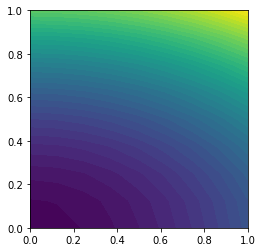

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


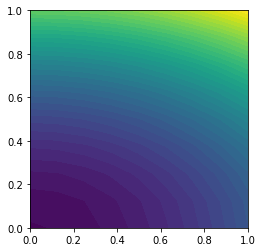

In [77]:
"""
FEniCS tutorial demo program: Diffusion of a Gaussian hill.

  u'= Laplace(u) + f  in a square domain
  u = u_D             on the boundary
  u = u_0             at t = 0

  u_D = f = 0

The initial condition u_0 is chosen as a Gaussian hill.
"""


'''
T = 1.0            # final time
num_steps = 1     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
                 degree=2, a=5)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - u_n*v*dx

K = assemble(dot(grad(u), grad(v))*dx)
'''

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Function(V)
fc = beta - 2 - 2*alpha
f.vector()[:] = fc

K = assemble(dot(grad(u), grad(v))*dx)
M = assemble(u*v*dx)
b = assemble(fc*v*dx)


def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(beta), boundary)

bc.apply(M)

def dydt(t, u):
    rhs = Function(V)
    rhs.vector()[:] = (-1)*K*u + b
    ue = Function(V)
    bc.apply(rhs.vector())
    solve(M, ue.vector(), rhs.vector())
    return (ue.vector());

def jac(t, u):
    j=-1*K
    return j.array();

t0 = 0  
solver = ode(dydt, jac).set_integrator('vode', method='bdf', order=15, with_jacobian=True)
solver.set_initial_value(u_n.vector(), t0)

t_out=[]
while solver.successful() and solver.t < T:
    solver.integrate(solver.t+dt, step=True)
    t_out.append(solver.t)
    # print("%g" % r.t); 
    # print(r.y)
    # print("%g %g" % (r.t, r.y))
    
print(t_out)    
u=Function(V);    
u.vector()[:]=solver.y[:];
plot(u)

u_D.t = T;
ue = project(u_D, V);
plt.figure();
plot(ue)

u.vector()[:] -= ue.vector()[:];

print(u.vector().norm("l2"))

References

https://stackoverflow.com/questions/12926393/using-adaptive-step-sizes-with-scipy-integrate-ode

